# Assignment — Link Prediction

In [1]:
!pip install gensim==3.7.0 -q

     |████████████████████████████████| 24.2MB 2.2MB/s 


In [2]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from gensim.models.word2vec import Word2Vec
from sklearn.metrics import roc_curve, auc
from tqdm.notebook import tqdm
import requests

In [3]:
url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/email-Eu-core-temporal.txt'
open('email-Eu-core-temporal.txt', 'wb').write(requests.get(url).content)

5517753

### Task 1. Similarity based link prediction (1.5 points)

Consider link prediction on the [e-mails network](http://snap.stanford.edu/data/email-Eu-core-temporal.html) where nodes are members of a research institution and edges are e-mails given with timestamps. The goal is to predict occurrence of edges in the test time period using information from the train time period only.

In [4]:
email_df = pd.read_csv(
    'email-Eu-core-temporal.txt', 
    delimiter=' ', 
    names=['sender', 'receiver', 'timestamp']
)
email_df.head()

,sender,receiver,timestamp
0,582,364,0
1,168,472,2797
2,168,912,3304
3,2,790,4523
4,2,322,7926


Next, consider the following preprocessing procedure:
1. Select edges by given train and test time periods, for example, [0, 1000) is train and [1000, 2000) is test
2. Build a _core_ — a network where every edge occurs at least $k_\text{train}$ times in the train time period or at least $k_\text{test}$ times in the test time period. Let the core be undirected, so occurrences edges (1, 0) and (0, 1) are computed together.
3. From the core, select a train set of edges $E_\text{train}$ that occur for the first time in the train period. All others are included to $E_\text{test}$.

Write a function `train_test_edges` that takes a pd.DataFrame `email_df` with e-mail network, a tuple with the train time period borders `train_period`, say, (0, 1000), a similar tuple `test_period`, the number of edges occurrences `ktrain` and `ktest`. The function returns two lists with tuples — train and test edges. Every edge is returned of the form where the first node is less than the second, for example [(1, 2), (2, 3)] is ok, but [(2, 1), (3, 2)] is wrong.

In [5]:
def train_test_edges(email_df, train_period, test_period, ktrain, ktest):
    email_temp = email_df.copy()
    email_temp = email_temp[(train_period[0] <= email_temp.timestamp) & (email_temp.timestamp < test_period[1])]
    
    email_temp['from'] = email_temp[['sender', 'receiver']].min(axis=1)
    email_temp['to'] = email_temp[['sender', 'receiver']].max(axis=1)
    email_temp = email_temp.drop(['sender', 'receiver'], axis=1)
    email_temp = email_temp.set_index(['from', 'to'])
    
    email_train = email_temp[email_temp.timestamp < train_period[1]]
    email_train = email_train.groupby(['from', 'to']).count()
    train_core = email_train[email_train.timestamp >= ktrain].index.tolist()
    
    email_test = email_temp[test_period[0] <= email_temp.timestamp]
    email_test = email_test.groupby(['from', 'to']).count()
    test_core = email_test[email_test.timestamp >= ktest].index.tolist()
    
    core =list(set(train_core + test_core))
    email_first = email_temp.loc[core].groupby(['from', 'to']).min()
    train_edges = email_first[email_first.timestamp < train_period[1]].index.tolist()
    test_edges = email_first[test_period[0] <= email_first.timestamp].index.tolist()
    
    return train_edges, test_edges

In [6]:
train_edges, test_edges = train_test_edges(email_df, (1e7, 2e7), (2e7, 2.5e7), 3, 3)
_train_edges, _test_edges = np.array(train_edges), np.array(test_edges)
assert np.all(_train_edges[:, 0] < _train_edges[:, 1])
assert np.all(_test_edges[:, 0] < _test_edges[:, 1])
assert len(set(train_edges).intersection(test_edges)) == 0
assert _train_edges.shape == (4147, 2)
assert _test_edges.shape == (418, 2)

The similarity based algorithm:
1. Compute similarity matrix for all pairs of nodes except $E_\text{train}$
2. Order that pairs in descending of similarity
3. Select some threshold and predict links for all pairs above the threshold

Write a function `sim_link_prediction` that takes a list with train edges and test edges. The function predicts links and returns a tuple with metrics: 
* two np.arrays: FPR (false positive rate) and TPR (true positive rate) in descending of thresholds obtained by Jaccard coefficient, `nx.jaccard_coefficient`
* the same, by Adamic/Adar index, `nx.adamic_adar_index`
* the same, by resource allocation index, `nx.resource_allocation_index`

_Hint: use `sklearn.metrics.roc_curve`._

In [7]:
def sim_link_prediction(train_edges, test_edges):
  nodes = set(np.array((train_edges + test_edges)).flatten())
  
  G_complete = nx.complete_graph(nodes)
  all_edges = set(G_complete.edges)
  possible_edges = list(all_edges.difference(set(train_edges)))
  possible_edges_series = pd.Series(possible_edges)
  y_true = possible_edges_series.isin(test_edges).tolist()
  
  G = nx.Graph()
  G.add_nodes_from(nodes)
  G.add_edges_from(train_edges)
 
  results = []
  for m in (nx.jaccard_coefficient, nx.adamic_adar_index, nx.resource_allocation_index):
    fpr, tpr, _ = roc_curve(y_true, [v for _, _, v in m(G, possible_edges)])
    results.append((fpr, tpr))
  return results[0], results[1], results[2]

In [8]:
jac, adam, res = sim_link_prediction(train_edges, test_edges)

In [9]:
assert jac[0].shape == jac[1].shape
assert adam[0].shape == adam[1].shape
assert res[0].shape == res[1].shape
assert round(auc(jac[0], jac[1]), 4) == 0.8371
assert round(auc(adam[0], adam[1]), 4) == 0.8500
assert round(auc(res[0], res[1]), 4) == 0.8495

Let us look at ROC AUC curve to compare similaritites.

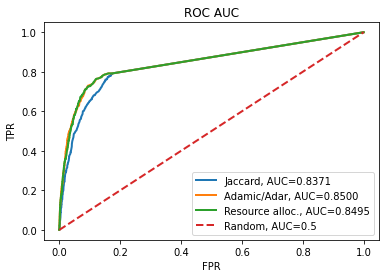

In [10]:
cases = [[jac[0], jac[1], 'Jaccard'], 
         [adam[0], adam[1], 'Adamic/Adar'], 
         [res[0], res[1], 'Resource alloc.']]
for fpr, tpr, label in cases:
    plt.plot(fpr, tpr, lw=2, 
             label='{}, AUC={:.4f}'.format(label, auc(fpr, tpr)))
plt.plot([0, 1], [0, 1], lw=2, linestyle='--', label='Random, AUC=0.5')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC AUC')
plt.legend()
plt.show()

### Task 2. SVD node embeddings (1.5 points)

Similarly to the node classification task, node embeddings could be helpful in the link prediction problem. The simplest way to obtain embeddings is to decompose some graph representation. However, in the given task, it could be helpful to factorize proximity matrices.

Firstly, you need to calculate similarity matrix. `adamic_adar_similarity_matrix` function takes `train_edges` as input, calculate Adamic/Adar index between each node pairs and returns np.array with its values.

In [11]:
def adamic_adar_similarity_matrix(train_edges):
    maxNodeValue = max(np.array(train_edges).flatten())
    G  = nx.Graph()
    G.add_nodes_from(np.arange(maxNodeValue + 1))
    G.add_edges_from(train_edges)

    similarity = np.zeros((maxNodeValue + 1 ,maxNodeValue + 1 ))
    for i, j, v in nx.adamic_adar_index(G):
      similarity[i,j] = v

    return similarity

In [12]:
adar_sim_matrix = adamic_adar_similarity_matrix(train_edges)
assert adar_sim_matrix.shape == (1005, 1005)
assert round(adar_sim_matrix[0, 2], 4) == 0.8523

Usually, graphs are sparse, so there is a high imbalance between positive (edge exists) and negative classes.
To eliminate this problem, we can use the undersampling technique. The `negative_sampling` function should sample the unexisted edges from our graph, so they are the most similar by the number of common neighbors. The result is the list of tuples with edges (similar to the `train_edges`).

In [13]:
def negative_sampling(train_edges, test_edges):
    maxNodeValue = max(np.array(train_edges).flatten())
    G = nx.Graph()
    G.add_nodes_from(np.arange(maxNodeValue + 1))
    G.add_edges_from(train_edges + test_edges)
    A = nx.to_numpy_array(G)
    similarity = A.dot(A)
    ids = set(np.flatnonzero(similarity))  - set(np.flatnonzero(nx.to_numpy_array(G)))
    possible_edges = []
    for i in ids:
      if i // (maxNodeValue + 1) != i % (maxNodeValue + 1):
        possible_edges.append((i // (maxNodeValue + 1), i % (maxNodeValue + 1),similarity[i // (maxNodeValue + 1),i % (maxNodeValue + 1)]))
    possible_edges = np.array(possible_edges, dtype = [('source', int) ,('target',int),('weight', float)])
    possible_edges.sort(axis =0 , order = 'weight')

    return [(i,j) for i,j,_ in possible_edges[-len(test_edges):]]


In [14]:
negatives = negative_sampling(train_edges, test_edges)
assert len(negatives) == len(test_edges)
print(len(set(negatives) & set(test_edges)) )
assert len(set(negatives) & set(test_edges)) == 0

np.random.seed(0)
validation = np.array(negatives + test_edges)[np.random.permutation(len(negatives) * 2)]
y_true = [int(tuple(i) in test_edges) for i in validation]

0


Here you need to define `inner_product_decoder` function. It takes an array with node embeddings and a list of test edges. It should return np.array with the recovered score calculated by the dot product of embeddings for different nodes.

In [15]:
def inner_product_decoder(embeddings, test_edges):
  test_edges = np.array(test_edges)
  return (embeddings[test_edges[:,0]]* embeddings[test_edges[:,1]]).sum(axis = 1)

In [16]:
from sklearn.decomposition import TruncatedSVD

embeddings = TruncatedSVD(n_components=8).fit_transform(adar_sim_matrix)
print(len(embeddings))
scores = inner_product_decoder(embeddings, validation)
tpr, fpr, _ = roc_curve(y_true, scores)
assert round(auc(fpr, tpr), 3) == 0.843

1005


### Task 3. Edge embeddings (3 points)

In the previous task, we train node level embeddings. However, for LPP, we need to have edge representation and decide whether to connect incident nodes or not.

You will need to compare several techniques of edge embedding calculation from the [paper](https://peerj.com/articles/cs-172/#table-2).

Compare the different vector aggregations as features for `sklearn.linear_model.LogisticRegression` with default hyperparameters.

All following functions should return np.array with embeddings of edges from edges param.

Average operator is simple elementwise average of node embeddings

In [17]:
def average_operator(G, embeddings, edges):
   result = []
   for edge in edges:
      result.append((embeddings[edge[0]]+ embeddings[edge[1]])/2.0)
    
   return np.array(result)



In [18]:
G_train = nx.Graph()
G_train.add_nodes_from(np.arange(max(set(sum(train_edges, ())) | set(sum(test_edges, ())))))
G_train.add_edges_from(train_edges)
assert round(average_operator(G_train, embeddings, validation[:1])[0, 0], 4) == 18.2539

Hadamard product is an elementwise product of node embeddings

In [19]:
def hadamard_operator(G, embeddings, edges):
   result = []
   for edge in edges:
      result.append((embeddings[edge[0]] * embeddings[edge[1]]))
    
   return np.array(result)

In [20]:
assert round(hadamard_operator(G_train, embeddings, validation[:1])[0, 0], 4) == 333.1554

Weighted L1 is a absolute of elementwise difference between node embeddings

In [21]:
def weighted_l1_operator(G, embeddings, edges):
   result = []
   for edge in edges:
      result.append((np.abs(embeddings[edge[0]] - embeddings[edge[1]])))
    
   return np.array(result)

In [22]:
assert round(weighted_l1_operator(G_train, embeddings, validation[:1])[0, 0], 4) == 0.4436

Weighted L2 is a square of elementwise difference between node embeddings

In [23]:
def weighted_l2_operator(G, embeddings, edges):
   result = []
   for edge in edges:
      result.append((embeddings[edge[0]] - embeddings[edge[1]])**2)
    
   return np.array(result)

In [24]:
assert round(weighted_l2_operator(G_train, embeddings, validation[:1])[0, 0], 4) == 0.1968

Neighbor weighted L1 is a absolute of elementwise difference between mean embeddings of node neigbors with itself

In [25]:
def neighbor_weighted_l1_operator(G, embeddings, edges):
    
  result = []
  for edge in edges:
    n1 = (list(nx.neighbors(G,edge[0])))
    n2 =(list(nx.neighbors(G,edge[1])))
    n1.append(edge[0])
    n2.append(edge[1])
    result1 = 0
    result2 = 0
    for i in n1:
      node = int(i)
      result1 += (embeddings[node])
    
    for i in n2:
      node = int(i)
      result2 += (embeddings[node])
    
    result.append(np.abs((result1/len(n1)) - (result2/len(n2))))

  return np.array(result)


In [26]:
assert round(neighbor_weighted_l1_operator(G_train, embeddings, validation[:1])[0, 0], 4) == 0.2344

Neighbor weighted L1 is a square of elementwise difference between mean embeddings of node neigbors with itself

In [27]:
def neighbor_weighted_l2_operator(G, embeddings, edges):
   
  result = []
  for edge in edges:
    n1 = (list(nx.neighbors(G,edge[0])))
    n2 =(list(nx.neighbors(G,edge[1])))
    n1.append(edge[0])
    n2.append(edge[1])
    result1 = 0
    result2 = 0
    for i in n1:
      node = int(i)
      result1 += (embeddings[node])
    
    for i in n2:
      node = int(i)
      result2 += (embeddings[node])    
    result.append(((result1/len(n1)) - (result2/len(n2)))**2)

  return np.array(result)

In [28]:
assert round(neighbor_weighted_l2_operator(G_train, embeddings, validation[:1])[0, 0], 4) == 0.0549

In [29]:
from sklearn.linear_model import LogisticRegression

operators = {
    "average_operator": average_operator,
    "hadamard_operator": hadamard_operator,
    "weighted_l1_operator": weighted_l1_operator,
    "weighted_l2_operator": weighted_l2_operator,
    "neighbor_weighted_l1_operator": neighbor_weighted_l1_operator,
    "neighbor_weighted_l2_operator": neighbor_weighted_l2_operator
}

train_split = int(len(validation) * 0.8)
res = {}
for nm, f in operators.items():
    lr = LogisticRegression()
    e = f(G_train, embeddings, validation)
    lr.fit(e[:train_split], y_true[:train_split])
    preds = lr.predict_proba(e[train_split:])[:, 1]
    fpr, tpr, _ = roc_curve(y_true[train_split:], preds)
    res[nm] = {
        'fpr': fpr,
        'tpr': tpr
    }

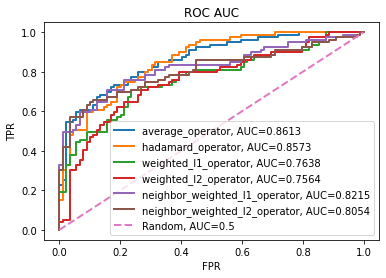

In [30]:
for label, v in res.items():
    fpr, tpr = v['fpr'], v['tpr']
    plt.plot(fpr, tpr, lw=2, 
             label='{}, AUC={:.4f}'.format(label, auc(fpr, tpr)))
plt.plot([0, 1], [0, 1], lw=2, linestyle='--', label='Random, AUC=0.5')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC AUC')
plt.legend()
plt.show()

### Task 4. Walklets (4 points)

Walklets (Perozzi, Kulkarni & Skiena, 2016) use a weighted combination of embeddings of powers of adjacency matrix $A$, $A^2$, …, $A^k$ to reduce the bias of Deepwalk for low-order proximities, and approximates computing $A^i$ by skipping nodes using short random walks (Perozzi et al., 2017).

The general idea is that we need to catch global graph level information for the link prediction task, not only local neighbourhood like in case with DeepWalks.

Firstly, we need to sample some random walks.

In [41]:
# you can use this function from last task from previous seminar
import random

def random_walks(G, n_walks, path_length):
    initial_result = []
    nodes = G.nodes
    for i in nodes: 
        for a in range(0, n_walks):     
            nextw = [] 
            current = i 
            for b in range(0, path_length):      
                nextw.append(current)
                ar = np.array(G[current])
                current = np.random.choice(ar)  
            initial_result.append(nextw)
    final_result = np.array(initial_result)
    return final_result

In [42]:
np.random.seed(0)
G = nx.karate_club_graph()
walks = random_walks(G, 10, 5)

assert walks.shape == (34*10, 5)
for i, j in zip(walks[0, :-1], walks[0, 1:]):
    assert G.has_edge(i, j)
assert np.all(walks[:, 0] == np.repeat(np.arange(34), 10))

When we have random walks, we can add skips to them. Function `make_skips` separates a random walk `walk` on the several walks with steps between each `node` equal to the `length`. It returns list of lists with random walks

In [47]:
def make_skips(walk, length):

    step_walk = []

    for i in range(0, len(walk) + 1, length):
      step_walk.append(walk[i : i + length])

    return step_walk

In [48]:
skipped = make_skips(walks[0], 2)
assert len(skipped) == 3
assert len(skipped[1]) == 2
assert skipped[1][1] == 17

[array([ 0, 17]), array([ 1, 17]), array([0])]
[ 0 17  1 17  0]
17


Now, you need to define the function that will extract random walks with skips from the list of random walks and return another list of random walks, but with skips

In [49]:
def make_skips_dataset(input_walks, length):
    res = []
    for walk in input_walks:
        skips = make_skips(walk, length)
        res = res + skips
    return res

In [50]:
skipped = make_skips_dataset(walks, 2)
assert len(skipped) == 1020
assert len(skipped[1]) == 2
assert skipped[1][1] == 17

To train embedding you need to know the set of nodes, sampled random walks without skips, size of the maximal desired skip (window_size) and dimension of embedding for the one skip.

The function `train_embedding` should work as follows:
For each skip_length between `1` and `window_size + 1`
1. Create dataset with splits
2. Train Word2Vec model on the created dataset with given vector_size, min_count=1, sg=1 and window=1.
3. save embeddings for the given step

After all iterations you need to take a mean of received embeddings for a node from each step. Finally, we return np.array with embeddings ordered by the id of node, if node id has no embedding, then use np.zeros(vector_size)

In [51]:
def train_embedding(nodes, walks, window_size=5, vector_size=8):
    result = np.zeros((len(nodes), 8))
    for i in range(1, 6):
        dataset = make_skips_dataset(walks, i)
        list_of_walks = []
        for walk in dataset:
            list_of_walks.append(list(walk.astype(str)))
        model = Word2Vec(size=vector_size, window=1, min_count=1, sg=1)
        model.build_vocab(list_of_walks)
        model.train(list_of_walks, total_examples=model.corpus_count, epochs=5)   
        for j in range(len(nodes)):
            if str(nodes[i]) in model.wv:
                result[j] += model.wv[str(nodes[i])]
            else:
                result[j] += np.zeros(vector_size)
    result = result / 5
    return result

In [52]:
np.random.seed(0)
G = nx.Graph(train_edges)
nodes = np.arange(max(set(sum(train_edges, ())) | set(sum(test_edges, ()))) + 1)
walks = random_walks(G, 10, 5)
embeddings = train_embedding(nodes, walks)
assert embeddings.shape == (1005, 8)
# assert round(embeddings[0, 0], 4) == -0.1768

In [53]:
operators = {
    "average_operator": average_operator,
    "hadamard_operator": hadamard_operator,
    "weighted_l1_operator": weighted_l1_operator,
    "weighted_l2_operator": weighted_l2_operator,
    "neighbor_weighted_l1_operator": neighbor_weighted_l1_operator,
    "neighbor_weighted_l2_operator": neighbor_weighted_l2_operator
}

train_split = int(len(validation) * 0.8)
res = {}
for nm, f in operators.items():
    lr = LogisticRegression()
    e = f(G_train, embeddings, validation)
    lr.fit(e[:train_split], y_true[:train_split])
    preds = lr.predict_proba(e[train_split:])[:, 1]
    fpr, tpr, _ = roc_curve(y_true[train_split:], preds)
    res[nm] = {
        'fpr': fpr,
        'tpr': tpr
    }

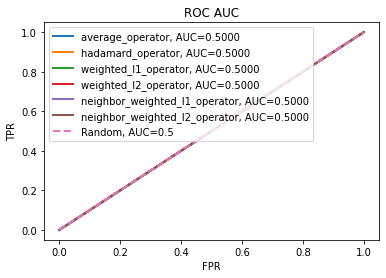

In [54]:
for label, v in res.items():
    fpr, tpr = v['fpr'], v['tpr']
    plt.plot(fpr, tpr, lw=2, 
             label='{}, AUC={:.4f}'.format(label, auc(fpr, tpr)))
plt.plot([0, 1], [0, 1], lw=2, linestyle='--', label='Random, AUC=0.5')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC AUC')
plt.legend()
plt.show()